In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *
from statannot import add_stat_annotation

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
sns.set_style('white')

# Setup

In [24]:
EXPERIMENT = 6
SKIP_BOOT = False

if EXPERIMENT in (5, 7, 8):
    print(f'Use exp{EXPERIMENT}.ipynb')
    exit()

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip" + "\n")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].rename(columns={'wid': 'pid'}).set_index('pid').copy()
full_pdf = pdf.copy()
mdf = data['trials'].rename(columns={'wid': 'pid'}).set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

# Normalize score by optimal performance (chance is zero for these experiments)
with open('mouselab_maxscores.json') as f:
    maxscores = json.load(f)

test_env = {
    1: 'basic',
    2: 'big',
    3: 'big',
    4: 'unstructured',
    6: 'basic'
}
maxscore = {'training': maxscores['basic'], 
            'test': maxscores[test_env[EXPERIMENT]]}
mdf.score *= (100/mdf.block.apply(maxscore.get))

full_pdf = pdf.copy()

if EXPERIMENT == 3:
    pdf.query('completed_1', inplace=True)
else:
    pdf.query('completed', inplace=True)
    
if EXPERIMENT == 6:
    pdf.rename(columns={'with_info': 'information', 'with_reward': 'reward'}, inplace=True)
    fb_namer = {
        (0, 0): 'none',
        (1, 0): 'info_only',
        (0, 1): 'reward_only',
        (1, 1): 'both'
    }
    pdf['feedback'] = pdf.apply(lambda row: fb_namer[row.information, row.reward], axis=1)
    mdf['information'] = pdf.information
    mdf['reward'] = pdf.reward
    fb_order = list(fb_namer.values())
else:
    fb_order = [fb for fb in ['none', 'action', 'meta'] if fb in set(pdf.feedback)]

## Demographics

In [25]:
pids = list(pdf.index.unique())
sdf = data['survey'].rename(columns={'wid': 'pid'}).query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))
age.loc[age < 18] = None

write_tex('mean-age', f'${age.mean():.1f}$')
write_tex('min-age', f'${age.min():.0f}$')
write_tex('max-age', f'${age.max():.0f}$')

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
n_fem = gender.value_counts()['female']
write_tex("N-female", f'${n_fem}$')

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.feedback.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")
    
write_tex('mean-bonus', f'\${pdf.bonus.mean():.2f}')

wrote "$36.0$" to "stats/6/mean-age.tex"
wrote "$18$" to "stats/6/min-age.tex"
wrote "$87$" to "stats/6/max-age.tex"
wrote "$204$" to "stats/6/N-female.tex"
wrote "$417$" to "stats/6/N-total.tex"
wrote "$105$" to "stats/6/N-both.tex"
wrote "$104$" to "stats/6/N-reward_only.tex"
wrote "$104$" to "stats/6/N-info_only.tex"
wrote "$104$" to "stats/6/N-none.tex"
wrote "\$1.05" to "stats/6/mean-bonus.tex"


In [26]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)

pdf.feedback = pd.Categorical(pdf.feedback, fb_order, ordered=True)    
mdf['feedback'] = pdf.feedback
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

In [27]:
if EXPERIMENT == 3:
    dropped = pdf.query('not completed').feedback.value_counts()
    rate = dropped / pdf.feedback.value_counts()
    for fb in fb_order:
        write_tex(f'N-drop-{fb}', dropped[fb])
        write_tex(f'drop-rate-{fb}', f'${rate[fb]*100:.1f}\%$')
    write_tex('return-rate', f'${pdf.completed.mean()*100:.1f}\%$')
    write_tex('return-N', f'${pdf.completed.sum()}$')
    pdf.query('completed', inplace=True)
    
# pd.Series(pdf.index).to_csv(f'pids/{EXPERIMENT}.csv', index=False, header=False)

In [8]:
small_leaves = {3,4,7,8,11,12}
transfer_leaves = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if not row.clicks:
        return False
    first = row.clicks[0]
    transfer =  EXPERIMENT in (2, 3) and row.block == "test"
    leaves = transfer_leaves if transfer else small_leaves
    return first in leaves

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)
pdf['first_backward'] = mdf.query('block == "train" and trial_index == 0').backward

def n_leaf(row):
    if not row.clicks:
        return False
    transfer =  EXPERIMENT in (2, 3) and row.block == "test"
    leaves = transfer_leaves if transfer else small_leaves
    return sum(click in leaves for click in row.clicks)

mdf['n_leaf'] = mdf.apply(n_leaf, axis=1).astype(int)

In [9]:
if EXPERIMENT not in (1, 6, 7):  # run before this was a problem
    write_tex('N-drop-previous', sum(pdf.previously_participated != "No"))
    print(pdf.previously_participated.value_counts())
    pdf = pdf.query('previously_participated == "No"')
    # pdf['first_backward'] = mdf.query('trial_index == 0').backward
    # pdf = pdf.query('not first_backward')
    mdf = mdf.loc[pdf.index]

wrote "18" to "stats/3/N-drop-previous.tex"
No          230
Yes          13
Not sure      5
Name: previously_participated, dtype: int64


In [10]:
n_drop = len(full_pdf) - len(pdf)
write_tex('N-drop', f'{n_drop}')
write_tex('percent-drop', f'{100 * n_drop / len(full_pdf):.1f}\%')

wrote "104" to "stats/3/N-drop.tex"
wrote "31.1\%" to "stats/3/percent-drop.tex"


In [11]:
pd.Series(pdf.index).to_csv(f'../data/{EXPERIMENT}/included_pids.csv', index=False, header=True)

## Setup Plotting 

In [12]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf']).plot

sns.set_style('whitegrid')
blue, orange = sns.color_palette('tab10')[:2]
gray = (0.5,)*3
red = (0.93, 0.21, 0.22)
yellow = (0.92, 0.77, 0.22)
palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}


palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}

nice_names = {
    'meta': 'Metacognitive\nFeedback',
    'action': 'Action\nFeedback',
    'none': 'No\nFeedback',
    'feedback': 'Feedback',
    'info_only': 'Info\nOnly',
    'reward_only': 'Delay \nOnly',
    'both': 'Info &\nDelay',
    'score': 'Relative Score',
    'test': 'Relative Test Score',
    'backward': 'Proportion Planning Backward'
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None):
    if ax is None:
        ax = plt.gca()
        
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=[nice_names.get(l, l).replace('\n', ' ') 
                                   for l in labels[1:]])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Test score

In [13]:
def write_kruskal(name):
    out = %R kruskal.test($name ~ feedback, data=rdf)
    out = dict(out.items())
    df = out["parameter"][0]
    p = pval(out["p.value"][0])
    stat = out["statistic"][0]
    write_tex(f'{name}-kruskal', rf'$H = {stat:.2f}, {p}$')

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std =  np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

import re
independence_results = {}
def write_independence_test(y, a, b, alternative='two.sided'):
    # oddly, feedback == b tests a > b
    out = %R independence_test($y ~ feedback == "$b",\
                               data=filter(rdf, feedback %in% c("$a", "$b")),\
                               alternative="$alternative")
    out = str(out)
    match = re.search('Z = (.*), p-value = (.*)', out)
    try:
        z, p = map(float, match.groups())
    except:
        print('Cannot parse independence test')
        print(out)
        raise Exception()
    
    x = rdf.set_index('feedback')[y]
    d = cohen_d(x.loc[a], x.loc[b])
    write_tex(f'independence-{y}-{a}-{b}', f'$d = {d:.2f}, Z = {z:.2f}, {pval(p)}$')
    independence_results[(y, a, b)] = p

rdf = pdf[['test', 'feedback']].rename(columns={
    'test': 'score'
})

In [14]:
%%R -i rdf
library(dplyr)
library(coin)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: survival



In [15]:
write_kruskal('score')

wrote "$H = 28.66, p < .001$" to "stats/3/score-kruskal.tex"


In [16]:
if EXPERIMENT == 6:
    write_independence_test('score', 'both', 'none')
    write_independence_test('score', 'info_only', 'none')
    write_independence_test('score', 'reward_only', 'none')
    write_independence_test('score', 'reward_only', 'info_only')
    write_independence_test('score', 'both', 'reward_only')
    write_independence_test('score', 'both', 'info_only')
else:
    write_independence_test('score', 'meta', 'none')
    if 'action' in fb_order:
        write_independence_test('score', 'meta', 'action')
        write_independence_test('score', 'action', 'none')

wrote "$d = 0.69, Z = 4.04, p < .001$" to "stats/3/independence-score-meta-none.tex"
wrote "$d = 0.88, Z = 5.08, p < .001$" to "stats/3/independence-score-meta-action.tex"
wrote "$d = -0.20, Z = -1.25, p = .210$" to "stats/3/independence-score-action-none.tex"


figs/3/test_dist.pdf
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

action v.s. meta: Custom statistical test, P_val:1.000e-03
none v.s. meta: Custom statistical test, P_val:1.000e-03
figs/3/test.pdf


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

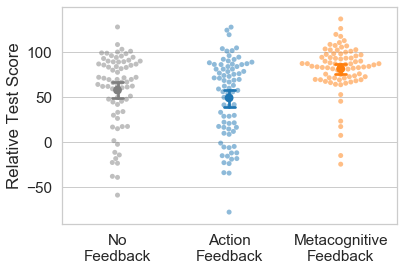

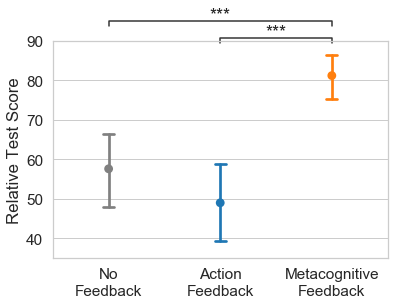

In [17]:
def plot_test(flag=''):
    plt.figure()
    if flag == 'dist':
        sns.swarmplot('feedback', 'test', data=pdf, palette=palette, alpha=0.5, order=fb_order, 
                      size=3.5 if EXPERIMENT == 6 else 5)
    sns.pointplot('feedback', 'test', data=pdf, palette=palette, order=fb_order, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('')
    plt.ylabel(nice_names['test'])
    test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    if EXPERIMENT in (2,3) and flag != 'dist':
        plt.ylim(35, 90)
    if flag != 'dist':
#         all_pairs = [('meta','none'), ('meta','action'), ('action','none')]
        nfb = len(fb_order)
        all_pairs = [(fb_order[j], fb_order[i]) for i in range(nfb-1) for j in range(i+1, nfb)]
        pairs = [(f1, f2) for (f1, f2) in all_pairs if independence_results['score', f1, f2] < .05]
        p = [independence_results['score', f1, f2] for (f1, f2) in pairs]
        p = [max(p, .001) for p in p] # at most 3 stars
        add_stat_annotation(plt.gca(), data=pdf, x='feedback', y='test', order=fb_order,
            box_pairs=pairs,
            pvalues=p, text_format='star', 
            fontsize=18, loc='outside', perform_stat_test=False, 
            line_offset=-.01, text_offset=-3
        )
#         plt.axhline(8.879, color='black')

figure(flag='dist')(plot_test)
figure()(plot_test)

In [18]:
N_BOOT = 10000
test_score = pdf.set_index('feedback').test

def ci(xs):
    return np.quantile(xs, [0.025, 0.975])

def boot_means(n=N_BOOT):
    r = {}
    for fb in fb_order:
        x = test_score.loc[fb]
        means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
        r[fb] = np.array(means)
    return r

In [19]:
if not SKIP_BOOT:
    bm = boot_means()
    for fb in fb_order:
        x = test_score.loc[fb].mean()
        a, b = ci(bm[fb])
        write_tex(f'mean-{fb}-percent', rf'${x:.1f}\%$')
        write_tex(f'mean-{fb}', rf'${x:.1f}$ points; 95\% CI: [${a:.1f}$, ${b:.1f}$]')
        write_tex(f'mean-{fb}-alt', rf'${x:.1f}$ points (95\% CI: [${a:.1f}$, ${b:.1f}$])')

wrote "$57.6\%$" to "stats/3/mean-none-percent.tex"
wrote "$57.6$ points; 95\% CI: [$48.1$, $66.3$]" to "stats/3/mean-none.tex"
wrote "$57.6$ points (95\% CI: [$48.1$, $66.3$])" to "stats/3/mean-none-alt.tex"
wrote "$49.0\%$" to "stats/3/mean-action-percent.tex"
wrote "$49.0$ points; 95\% CI: [$39.6$, $58.3$]" to "stats/3/mean-action.tex"
wrote "$49.0$ points (95\% CI: [$39.6$, $58.3$])" to "stats/3/mean-action-alt.tex"
wrote "$81.2\%$" to "stats/3/mean-meta-percent.tex"
wrote "$81.2$ points; 95\% CI: [$74.9$, $86.7$]" to "stats/3/mean-meta.tex"
wrote "$81.2$ points (95\% CI: [$74.9$, $86.7$])" to "stats/3/mean-meta-alt.tex"


# Learning curves

figs/3/learning_curve_backward.pdf


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

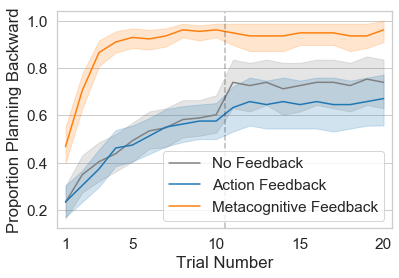

In [20]:
def learning_curve(var):
    df = mdf.copy()
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()
    
figure(var='backward')(learning_curve)

figs/3/learning_curve_score.pdf


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

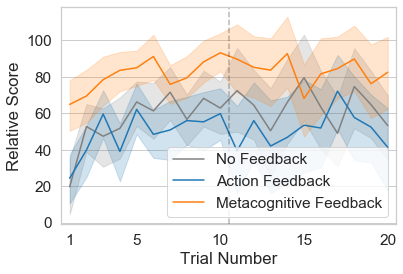

In [21]:
figure(var='score')(learning_curve)

# Process

## Summary in test block

In [22]:
def report_ratio(df, key):
    name = key.replace('_', '-')
    X = df.groupby(['feedback', key]).apply(len)
    rate = 100 * df.groupby('feedback')[key].mean()

    for c in fb_order:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

wrote "$67.5$\%" to "stats/3/backward-none-percent.tex"
wrote "$62.0$\%" to "stats/3/backward-action-percent.tex"
wrote "$93.6$\%" to "stats/3/backward-meta-percent.tex"


## Mediation

In [23]:
if EXPERIMENT in (4, 6):
    print("Mediation not implemented for this analysis")
    exit()

In [24]:
rdf = mdf.query('block == "test"').copy().rename(columns={'information': 'info'})
# rdf['feedback'] = (rdf.feedback != 'none').astype(int)

if EXPERIMENT == 6:
    factors = ['info', 'reward']
    for c in factors:
        rdf[c] = rdf[c].astype(float)
else:
    factors = ['action', 'meta']
    fb = rdf.pop('feedback')
    for c in factors:
        rdf[c] = (fb == c).astype(int)

rdf['clicked'] = rdf.clicked.astype(int)
rdf = rdf[[*factors, 'backward', 'clicked', 'n_clicks', 'score', 'trial_index', 'stim_i']].reset_index()
rdf.backward.fillna(0, inplace=True)
# rdf.trial_index = rdf.trial_index.astype(float)
# rdf.query('action == 0', inplace=True)
rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [25]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-144.228  -14.319    1.976   14.106   78.905 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.958      3.518   1.125    0.262    
backward      78.774      4.173  18.878   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25 on 228 degrees of freedom
Multiple R-squared:  0.6098,	Adjusted R-squared:  0.6081 
F-statistic: 356.4 on 1 and 228 DF,  p-value: < 2.2e-16



In [26]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-144.228  -14.319    1.976   14.106   78.905 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.958      3.518   1.125    0.262    
backward      78.774      4.173  18.878   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25 on 228 degrees of freedom
Multiple R-squared:  0.6098,	Adjusted R-squared:  0.6081 
F-statistic: 356.4 on 1 and 228 DF,  p-value: < 2.2e-16



In [27]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.1f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.2f}$, ${pval(p)}$')

wrote "$78.8$" to "stats/3/score-backward.tex"
wrote "$t(228) = 18.88$, $p < .001$" to "stats/3/score-backward-test.tex"


In [28]:
%%R
local({r <- getOption("repos")
       r["CRAN"] <- "https://cloud.r-project.org" 
       options(repos=r)
})
# install.packages('mediation')

In [29]:
%%R -i rdf -i EXPERIMENT -o back -o med_out
library(mediation)

if ('action' %in% colnames(rdf)) {
    back_fit = lm(backward ~ action + meta, data=rdf)
    score_fit = lm(score ~ backward + action + meta, data=rdf)
# } else if (EXPERIMENT == 6) {
#     back_fit = lm(backward ~ info + reward, data=rdf)
#     score_fit = lm(score ~ backward + info + reward)
} else {
    back_fit = lm(backward ~ meta, data=rdf)
    score_fit = lm(score ~ backward + meta, data=rdf)
}
med_out = mediate(back_fit, score_fit, treat="meta", mediator="backward")
back = summary(back_fit)
summary(med_out)

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.5.0





Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             19.970       10.312        29.19  <2e-16 ***
ADE               3.999       -4.096        11.99    0.34    
Total Effect     23.969       11.375        36.54  <2e-16 ***
Prop. Mediated    0.839        0.564         1.26  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 230 


Simulations: 1000 



In [30]:
back = dict(back.items())
df = back['df'][1]
for i, name in enumerate(fb_order[1:], start=1):
    est, std, t, p = back['coefficients'][i]
    write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.2f}$, ${pval(p)}$')

wrote "$t(227) = -0.91$, $p = .363$" to "stats/3/backward-lm-action.tex"
wrote "$t(227) = 4.30$, $p < .001$" to "stats/3/backward-lm-meta.tex"


In [31]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.1f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.1f}, {hi:.1f}], ${pval(p)}$')

wrote "20.0" to "stats/3/mediation-acme.tex"
wrote "95\% CI: [10.3, 29.2], $p < .001$" to "stats/3/mediation-acme-ci.tex"
wrote "4.0" to "stats/3/mediation-ade.tex"
wrote "95\% CI: [-4.1, 12.0], $p = .342$" to "stats/3/mediation-ade-ci.tex"
wrote "24.0" to "stats/3/mediation-total.tex"
wrote "95\% CI: [11.4, 36.5], $p < .001$" to "stats/3/mediation-total-ci.tex"
wrote "0.8" to "stats/3/mediation-prop.tex"
wrote "95\% CI: [0.6, 1.3], $p < .001$" to "stats/3/mediation-prop-ci.tex"


In [32]:
print("Success!")

Success!
